In [1]:
# NOTE - Shutdown vscode and restart it to make sure the kernel is updated

# Imports
import logging
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setup logging with INFO level
logging.basicConfig(level=logging.INFO)

# Customizable settings
MIN_NUM_VOTES = 1000
DAILY_WATCH_TIME = 1 # hours
CURRENT_AGE = 30 # years
DEATH_AGE = 80 # years
TITLE_TYPES = ['movie', 'tvSeries']

# Load data from TSV file
TITLES = 'title.basics.tsv'
TITLES_AKAS = 'title.akas.tsv'
RATINGS = 'title.ratings.tsv'

In [3]:
# Download fresh data from IMDb
DOWNLOAD = False

# Download IMDb data on a Mac
if DOWNLOAD:
    logging.info('Downloading IMDb data')
    os.system(f"curl -O https://datasets.imdbws.com/{TITLES}.gz")
    os.system(f"curl -O https://datasets.imdbws.com/{RATINGS}.gz")
    os.system(f"curl -O https://datasets.imdbws.com/{TITLES_AKAS}.gz")
    # Unzip the files overwriting the originals
    os.system(f"gunzip -f {TITLES}.gz")
    os.system(f"gunzip -f {RATINGS}.gz")
    os.system(f"gunzip -f {TITLES_AKAS}.gz")

logging.info(f"Data was last downloaded on {time.ctime(os.path.getmtime(TITLES))}")

INFO:root:Downloading IMDb data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  192M  100  192M    0     0  29.0M      0  0:00:06  0:00:06 --:--:-- 27.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7531k  100 7531k    0     0  29.0M      0 --:--:-- --:--:-- --:--:-- 28.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  424M  100  424M    0     0  6828k      0  0:01:03  0:01:03 --:--:-- 6681k
INFO:root:Data was last downloaded on Wed Feb 12 19:28:18 2025


In [37]:
# Load downloaded data into Pandas DataFrames
# This takes ~20 seconds on my machine
logging.info(f'Loading data from {TITLES}...')
titles_df = pd.read_csv(TITLES, sep='\t', header=0, low_memory=False)
logging.info(f'Loading data from {RATINGS}...')
ratings_df = pd.read_csv(RATINGS, sep='\t', header=0, low_memory=False)
logging.info(f'Loading data from {TITLES_AKAS}...')
akas_df = pd.read_csv(TITLES_AKAS, sep='\t', header=0, low_memory=False)

# Combine the two DataFrames on tconst column
raw_df = pd.merge(titles_df, ratings_df, on='tconst')
# Combine the two DataFrames on tconst and titleId column
raw_df = pd.merge(raw_df, akas_df, left_on='tconst', right_on='titleId')

logging.info("Done")

INFO:root:Loading data from title.basics.tsv...
INFO:root:Loading data from title.ratings.tsv...
INFO:root:Loading data from title.akas.tsv...
INFO:root:Done


In [52]:
# Define functions
def remove_outliers(df):
    # Get the 99th percentile of runtimeMinutes
    runtime_minutes_99th_percentile = df['runtimeMinutes'].quantile(0.99)
    # Filter out rows with runtimeMinutes greater than the 99th percentile
    return df[df['runtimeMinutes'] < runtime_minutes_99th_percentile]


def lifetime_watch_hours_remaining():
    return (DEATH_AGE - CURRENT_AGE) * 365 * DAILY_WATCH_TIME


def predict_total_lifespan_content(df):
    # Predict total duration of new content during lifespan
    # Keep index separate from year
    df_group_by_year = df.groupby('year').sum(numeric_only=True).reset_index()

    # Get current year
    current_year = pd.to_datetime('today').year
    # Exclude current year from data
    df_group_by_year = df_group_by_year[df_group_by_year['year'] < current_year]

    # Create trendline with quadratic fit instead of 4th degree
    z = np.polyfit(list(df_group_by_year['year']), df_group_by_year['runtimeHours'], 2)  # Changed from 4 to 2
    p = np.poly1d(z)

    # Extend trendline to year of death
    yod = current_year + DEATH_AGE - CURRENT_AGE
    x = np.arange(current_year, yod)

    # Find the area under the curve from current year to year of death, ensuring no negative values
    future_values = np.maximum(p(x), 0)  # Added this line
    area = np.trapz(future_values, x)  # Changed to use future_values

    # Write the fit equation (simplified for quadratic)
    fit_eqn = f"Runtime = {round(z[0], 2)}x^2 + {round(z[1], 2)}x + {round(z[2], 2)}"  # Changed equation format

    hours_existing_content = int(df['runtimeHours'].sum())
    hours_future_content = int(area)
    hours_total_content = hours_existing_content + hours_future_content
    logging.info(f"Hours of existing content: {hours_existing_content}")
    logging.info(f"Hours of future content: {hours_future_content}")
    logging.info(f"Hours of total content: {hours_total_content}")
#     logging.info(f"Days of future content: {int(area / 24)}")
    logging.info(fit_eqn)

    # Plot runtimeHours per year
    plot_runtime_hours(df_group_by_year, p, x, fit_eqn)

    return hours_total_content

def plot_runtime_hours(df_group_by_year, p, x, fit_eqn):
    # Plot runtimeHours per year
    plt.plot(df_group_by_year['year'], df_group_by_year['runtimeHours'])

    # Label the axes
    plt.xlabel('Year')
    plt.ylabel('Runtime (hours)')

    plt.plot(df_group_by_year['year'], p(df_group_by_year['year']), "r--")
    plt.plot(x, p(x), "r--")
    plt.text(0.5, 0.5, fit_eqn, fontsize=12, transform=plt.gcf().transFigure)



In [39]:
# Copy raw_df to df to preserve raw data
df = raw_df.copy()

# Prep data
# Convert runtimeMinutes to int
# Set any rows with errors to 0
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')

# Get all unique titleTypes
title_types = df['titleType'].unique()

# Target specific TITLE_TYPES
# All options: 'short', 'movie', 'tvSeries', 'tvShort', 'tvMovie', 'tvEpisode', 'tvMiniSeries', 'video', 'tvSpecial', 'videoGame'
df = df[df['titleType'].isin(TITLE_TYPES)]

# Remove runtimeMinutes outliers (99th percentile)
# We don't want 900hr movies skewing the data
df = remove_outliers(df)

# Remove films from India
rows_w_india = df.shape[0]
df = df[~df['region'].str.contains('IN', na=False)]
rows_wout_india = df.shape[0]
print(f"India entries removed: {rows_w_india-rows_wout_india}")

# Filter out rows with runtimeMinutes of 0
df = df[df['runtimeMinutes'] > 0]

# Filter out rows with numVotes less than MIN_NUM_VOTES
# These are media with "insufficient" reviews
df = df[df['numVotes'] > MIN_NUM_VOTES]

# Sum runtimeMinutes per year and remove \\N
df['year'] = pd.to_numeric(df['startYear'], errors='coerce').astype(pd.Int64Dtype())
df = df[df['year'] > 0]

# Add runtimeHours column
df['runtimeHours'] = df['runtimeMinutes'] / 60


India entries removed: 90067


In [40]:
# How much time will I have to watch new content?
lifetime_watch_hours_remaining()

18250

In [41]:
df['averageRating'].describe()
df_avg = df['averageRating'].mean()
print(f"Average Rating: {df_avg}")
# print(422115 / df_avg)

Average Rating: 6.497519733388715


INFO:root:Hours of existing content: 1938808
INFO:root:Hours of future content: 5037877
INFO:root:Hours of total content: 6976685
INFO:root:Runtime = 7.81x^2 + -30232.76x + 29268183.41


6976685

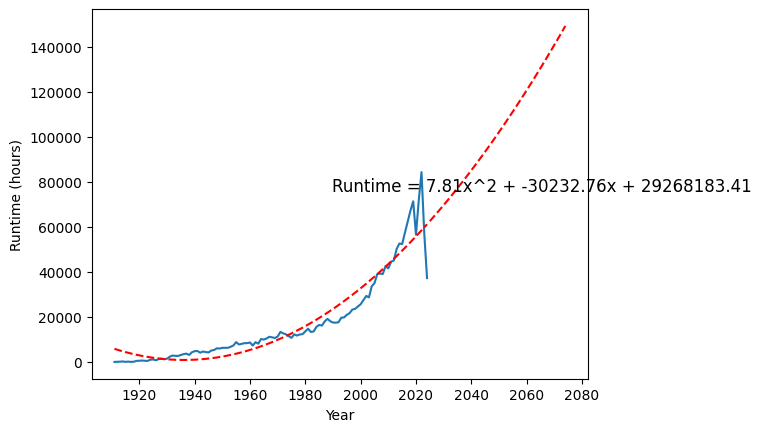

In [53]:


predict_total_lifespan_content(df)

INFO:root:Calculate curves for rating: 7.0
INFO:root:Hours of existing content: 616654
INFO:root:Hours of future content: 1350456
INFO:root:Hours of total content: 1967110
INFO:root:Runtime = 1.89x^2 + -7317.66x + 7069797.63
INFO:root:Calculate curves for rating: 7.01
INFO:root:Hours of existing content: 616654
INFO:root:Hours of future content: 1350456
INFO:root:Hours of total content: 1967110
INFO:root:Runtime = 1.89x^2 + -7317.66x + 7069797.63
INFO:root:Calculate curves for rating: 7.02
INFO:root:Hours of existing content: 616654
INFO:root:Hours of future content: 1350456
INFO:root:Hours of total content: 1967110
INFO:root:Runtime = 1.89x^2 + -7317.66x + 7069797.63
INFO:root:Calculate curves for rating: 7.029999999999999
INFO:root:Hours of existing content: 616654
INFO:root:Hours of future content: 1350456
INFO:root:Hours of total content: 1967110
INFO:root:Runtime = 1.89x^2 + -7317.66x + 7069797.63
INFO:root:Calculate curves for rating: 7.039999999999999
INFO:root:Hours of existing

INFO:root:Hours of total content: 1254188
INFO:root:Runtime = 1.27x^2 + -4913.98x + 4754647.68
INFO:root:Calculate curves for rating: 7.3499999999999925
INFO:root:Hours of existing content: 387347
INFO:root:Hours of future content: 866841
INFO:root:Hours of total content: 1254188
INFO:root:Runtime = 1.27x^2 + -4913.98x + 4754647.68
INFO:root:Calculate curves for rating: 7.359999999999992
INFO:root:Hours of existing content: 387347
INFO:root:Hours of future content: 866841
INFO:root:Hours of total content: 1254188
INFO:root:Runtime = 1.27x^2 + -4913.98x + 4754647.68
INFO:root:Calculate curves for rating: 7.369999999999992
INFO:root:Hours of existing content: 387347
INFO:root:Hours of future content: 866841
INFO:root:Hours of total content: 1254188
INFO:root:Runtime = 1.27x^2 + -4913.98x + 4754647.68
INFO:root:Calculate curves for rating: 7.379999999999992
INFO:root:Hours of existing content: 387347
INFO:root:Hours of future content: 866841
INFO:root:Hours of total content: 1254188
INFO:

INFO:root:Hours of existing content: 216986
INFO:root:Hours of future content: 490340
INFO:root:Hours of total content: 707326
INFO:root:Runtime = 0.72x^2 + -2800.56x + 2710198.54
INFO:root:Calculate curves for rating: 7.699999999999985
INFO:root:Hours of existing content: 216986
INFO:root:Hours of future content: 490340
INFO:root:Hours of total content: 707326
INFO:root:Runtime = 0.72x^2 + -2800.56x + 2710198.54
INFO:root:Calculate curves for rating: 7.709999999999985
INFO:root:Hours of existing content: 175174
INFO:root:Hours of future content: 420803
INFO:root:Hours of total content: 595977
INFO:root:Runtime = 0.67x^2 + -2594.29x + 2515939.27
INFO:root:Calculate curves for rating: 7.719999999999985
INFO:root:Hours of existing content: 175174
INFO:root:Hours of future content: 420803
INFO:root:Hours of total content: 595977
INFO:root:Runtime = 0.67x^2 + -2594.29x + 2515939.27
INFO:root:Calculate curves for rating: 7.729999999999984
INFO:root:Hours of existing content: 175174
INFO:roo

INFO:root:Calculate curves for rating: 8.039999999999978
INFO:root:Hours of existing content: 86084
INFO:root:Hours of future content: 233430
INFO:root:Hours of total content: 319514
INFO:root:Runtime = 0.41x^2 + -1606.96x + 1562677.07
INFO:root:Calculate curves for rating: 8.049999999999978
INFO:root:Hours of existing content: 86084
INFO:root:Hours of future content: 233430
INFO:root:Hours of total content: 319514
INFO:root:Runtime = 0.41x^2 + -1606.96x + 1562677.07
INFO:root:Calculate curves for rating: 8.059999999999977
INFO:root:Hours of existing content: 86084
INFO:root:Hours of future content: 233430
INFO:root:Hours of total content: 319514
INFO:root:Runtime = 0.41x^2 + -1606.96x + 1562677.07
INFO:root:Calculate curves for rating: 8.069999999999977
INFO:root:Hours of existing content: 86084
INFO:root:Hours of future content: 233430
INFO:root:Hours of total content: 319514
INFO:root:Runtime = 0.41x^2 + -1606.96x + 1562677.07
INFO:root:Calculate curves for rating: 8.079999999999977

INFO:root:Runtime = 0.26x^2 + -1026.09x + 1004824.24
INFO:root:Calculate curves for rating: 8.38999999999997
INFO:root:Hours of existing content: 32729
INFO:root:Hours of future content: 113498
INFO:root:Hours of total content: 146227
INFO:root:Runtime = 0.26x^2 + -1026.09x + 1004824.24
INFO:root:Calculate curves for rating: 8.39999999999997
INFO:root:Hours of existing content: 32729
INFO:root:Hours of future content: 113498
INFO:root:Hours of total content: 146227
INFO:root:Runtime = 0.26x^2 + -1026.09x + 1004824.24
INFO:root:Calculate curves for rating: 8.40999999999997
INFO:root:Hours of existing content: 23856
INFO:root:Hours of future content: 86174
INFO:root:Hours of total content: 110030
INFO:root:Runtime = 0.2x^2 + -797.51x + 781357.84
INFO:root:Calculate curves for rating: 8.41999999999997
INFO:root:Hours of existing content: 23856
INFO:root:Hours of future content: 86174
INFO:root:Hours of total content: 110030
INFO:root:Runtime = 0.2x^2 + -797.51x + 781357.84
INFO:root:Calcu

INFO:root:Hours of existing content: 5864
INFO:root:Hours of future content: 29389
INFO:root:Hours of total content: 35253
INFO:root:Runtime = 0.1x^2 + -388.0x + 383136.0
INFO:root:Calculate curves for rating: 8.749999999999963
INFO:root:Hours of existing content: 5864
INFO:root:Hours of future content: 29389
INFO:root:Hours of total content: 35253
INFO:root:Runtime = 0.1x^2 + -388.0x + 383136.0
INFO:root:Calculate curves for rating: 8.759999999999962
INFO:root:Hours of existing content: 5864
INFO:root:Hours of future content: 29389
INFO:root:Hours of total content: 35253
INFO:root:Runtime = 0.1x^2 + -388.0x + 383136.0
INFO:root:Calculate curves for rating: 8.769999999999962
INFO:root:Hours of existing content: 5864
INFO:root:Hours of future content: 29389
INFO:root:Hours of total content: 35253
INFO:root:Runtime = 0.1x^2 + -388.0x + 383136.0
INFO:root:Calculate curves for rating: 8.779999999999962
INFO:root:Hours of existing content: 5864
INFO:root:Hours of future content: 29389
INFO:

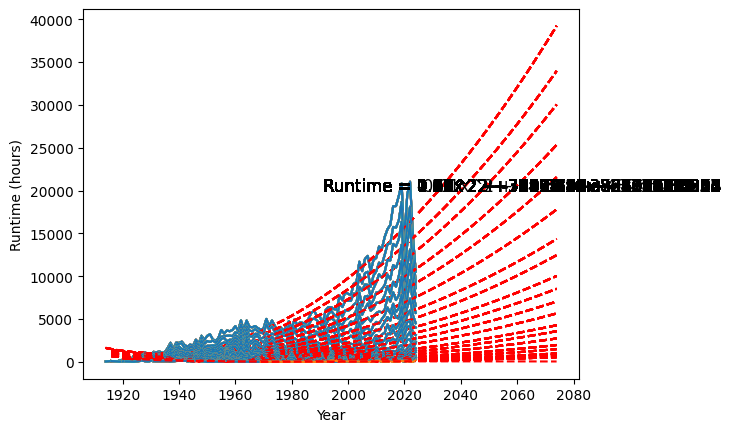

In [54]:
# FIXME - add predicted time already watched
# FIXME - add percentage of content you want to watch

# Find rating cutoff so that lifetime watch hours remaining equals total lifespan content
time_left = lifetime_watch_hours_remaining()

for rating in np.arange(7.0, 9.5, .01):
    logging.info(f"Calculate curves for rating: {rating}")
    df_cutoff = df[df['averageRating'] > rating]
    total_time = predict_total_lifespan_content(df_cutoff)

    if total_time < time_left:
        time_leftover = time_left - total_time
        logging.info(f"For {rating} cutoff rating, {total_time} hours of content with {time_leftover} time left over")
        logging.info(f"Your cutoff rating is {rating}!!")
        break

# TODO - there's definitely a better way to do this
# Calculate the cutoff rating using calculus without a for loop
# https://stackoverflow.com/questions/2828059/solving-linear-equations-involving-logarithms



In [55]:
# Plot stacked chart of int rating distribution per year
# Round averageRating to nearest integer
df['averageRatingInt'] = df['averageRating'].round(0).astype(int)

# Group averageRatingInt by year and sum runtimeHours
df_hours_by_rating = df.groupby(['year', 'averageRatingInt']).sum(numeric_only=True).reset_index()
# logging.info(df_hours_by_rating)

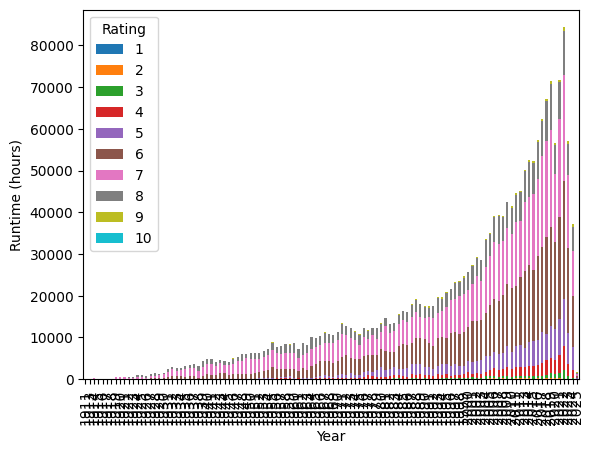

In [56]:
# plt.bar(df_hours_by_rating['year'], df_hours_by_rating[df_hours_by_rating['averageRatingInt']==1]['runtimeHours'])
# df_hours_by_rating[df_hours_by_rating['averageRatingInt']==1]['runtimeHours']
# df_hours_by_rating['year']
df_hours_by_rating['runtimeHours']

df_hours_by_rating = df_hours_by_rating.pivot(index='year', columns='averageRatingInt', values='runtimeHours').fillna(0)
# logging.info(df_hours_by_rating)

# Plot runtimeHours per year
# for x in range(1, 11):
#     plt.plot(df_hours_by_rating.index, df_hours_by_rating[x], label=x)

df_hours_by_rating.plot.bar(stacked=True)

# Stack the bars 1-10 from bottom to top
# Add labels to the plot
plt.xlabel('Year')
plt.ylabel('Runtime (hours)')
plt.legend(title='Rating')
plt.show()

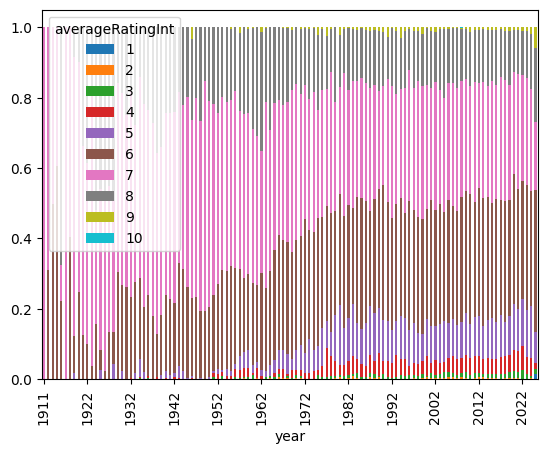

In [57]:
# Is it safe to assume rating-duration distributions stay similar over time?
# NO

df_hours_by_rating['total'] = df_hours_by_rating.sum(axis=1)
df_hours_by_rating = df_hours_by_rating.div(df_hours_by_rating['total'], axis=0)
df_hours_by_rating = df_hours_by_rating.drop(columns=['total'])
# logging.info(df_hours_by_rating)

# Plot as stacked bar chart
# df_hours_by_rating.plot.bar(stacked=True)

# Create a categorical index for the ratings so they are ordered correctly
df_hours_by_rating.index = pd.CategoricalIndex(df_hours_by_rating.index, categories=df_hours_by_rating.index, ordered=True)

# Plot the stacked bar chart
df_hours_by_rating.plot.bar(stacked=True)

plt.xticks(np.arange(0, len(df_hours_by_rating.index), 10))

plt.show()